In [1]:
# python libraries
import os
import sys
import dataclasses
from datetime import datetime
from pathlib import Path
from operator import methodcaller
from collections import OrderedDict
from dataclasses import dataclass
from typing import (
    List,
    Tuple,
    Dict,
    Any,
    Mapping,
    Callable
)
from enum import Enum
# adding the path
if not str(Path(os.getcwd()).parent) in sys.path:
    sys.path.append(str(Path(os.getcwd()).parent))

# numpy
import numpy as np

# torch
import torch
from torch import (
    nn,
    Tensor
    )
from torch.nn import functional as F


try:
    from torchmetrics import Accuracy
except:
    print(f"[INFO] Installing the torchmetrics")
    %pip install torchmetrics
    from torchmetrics import Accuracy

try:
    import torchinfo
except:
    print(f"[INFO] Installing the torchinfo")
    %pip install torchinfo
    import torchinfo

# helper function
try:
    import my_helper as helper
except:
    print("[INFO] Downloading the helper function from github")
    import requests
    response = requests.get("https://raw.githubusercontent.com/Lashi0812/PyTorch2/master/my_helper.py")
    with open("my_helper.py" ,"wb") as f:
        f.write(response.content)
    import my_helper as helper


## Connect Persistence memory
try :
    from google.colab import drive

    # Paths
    DRIVE_PATH = Path("/content/drive")
    MODEL_SAVE_PATH = Path("/content/drive/Othercomputers/My PC/drive/models")

    # mount drive
    drive.mount(str(DRIVE_PATH))
except:
    MODEL_SAVE_PATH = Path(os.getcwd())/"models"
    
device = "cuda" if torch.cuda.is_available() else "cpu"

[INFO] Installing the torchmetrics
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 9.7 MB/s eta 0:00:00
[INFO] Installing the torchinfo
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[INFO] Downloading the helper function from github
Mounted at /content/drive


# Network Design


## Conv Layer


In [2]:
def conv_block(num_channels: int) -> nn.Module:
    return nn.Sequential(
        nn.LazyBatchNorm2d(),
        nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=3, padding=1),
    )


## Dense Block

It use to concat the input and output so we can have we can capture more term in taylor series.


In [3]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs: int, num_channels: int) -> None:
        super().__init__()
        layers = []
        for _ in range(num_convs):
            layers.append(conv_block(num_channels))
        self.dense = nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        for conv in self.dense:
            y = conv(x)
            # concat the input and output along the channel dimension
            x = torch.cat((x, y), dim=1)
        return x


In [4]:
blk = DenseBlock(num_convs=2, num_channels=10)
X = torch.randn(size=(4, 3, 8, 8))
y = blk(X)
y.shape

# ? out_channel = in_channel + (num_convs *  num_channels)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([4, 23, 8, 8])

## Transition Layer

Which controls the complexity of the model , it reduce the dimension of channel using 1x1 conv


In [5]:
def transition_block(num_channels: int) -> nn.Module:
    return nn.Sequential(
        nn.LazyBatchNorm2d(),
        nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2),
    )

In [6]:
blk = transition_block(10)
blk(y).shape

torch.Size([4, 10, 4, 4])

## DenseNet Model

In [7]:
@dataclass(eq=False)
class DenseNet(helper.Classifier):
    start_channels:int = 64
    growth_rate:int = 32
    arch:Tuple[int] = (4,4,4,4)
    lr:float = 0.1
    num_classes:int = 10
    
    def __post_init__(self):
        super().__init__()
        cur_channels = self.start_channels
        self.net = nn.Sequential(self.b1())
        for i,num_conv in enumerate(self.arch,start=1):
            self.net.add_module(f"dense_blk{i}",DenseBlock(num_convs=num_conv,
                                                             num_channels=self.growth_rate))
            
            # num_channels after the dense block
            cur_channels += num_conv * self.growth_rate
            
            if i != len(self.arch):
                cur_channels //= 2
                self.net.add_module(f"trans_block{i}",transition_block(cur_channels))
        # adding the classifier layer
        self.net.add_module("last",nn.Sequential(
            nn.LazyBatchNorm2d(),nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),nn.Flatten(),
            nn.LazyLinear(self.num_classes)
        ))
    
    
    def b1(self):
        """Same Configuration as in the AlexNet"""
        return nn.Sequential(
            nn.LazyConv2d(self.start_channels,kernel_size=7,stride=2,padding=3),
            nn.LazyBatchNorm2d(),nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        )
        
    def dense_init(self,module:nn.Module):
        if isinstance(module,(nn.Linear,nn.Conv2d)):
            nn.init.kaiming_normal_(module.weight)

# Summary

In [8]:
torchinfo.summary(DenseNet(),input_size=(1,1,96,96),col_width=16,depth=2,
                  col_names=["kernel_size","input_size","output_size","num_params","mult_adds"],
                  row_settings=["var_names"])

Layer (type (var_name))                       Kernel Shape     Input Shape      Output Shape     Param #          Mult-Adds
DenseNet (DenseNet)                           --               [1, 1, 96, 96]   [1, 10]          --               --
├─Sequential (net)                            --               [1, 1, 96, 96]   [1, 10]          --               --
│    └─Sequential (0)                         --               [1, 1, 96, 96]   [1, 64, 24, 24]  3,328            7,372,928
│    └─DenseBlock (dense_blk1)                --               [1, 64, 24, 24]  [1, 192, 24, 24] 130,048          74,392,448
│    └─Sequential (trans_block1)              --               [1, 192, 24, 24] [1, 96, 12, 12]  18,912           10,672,512
│    └─DenseBlock (dense_blk2)                --               [1, 96, 12, 12]  [1, 224, 12, 12] 167,168          23,907,456
│    └─Sequential (trans_block2)              --               [1, 224, 12, 12] [1, 112, 6, 6]   25,648           3,629,248
│    └─DenseBlock (

# Training

In [9]:
data = helper.FashionMNIST(batch_size=128,resize=(96,96))
model = DenseNet(lr=0.01)
model.apply_init([next(iter(data.train_dataloader()))[0]],model.dense_init)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



In [10]:
trainer = helper.Trainer(max_epochs=10,model_save_path=MODEL_SAVE_PATH,verbose=True)

Training the model in cuda


[INFO] Entering FIT
[INFO] Entering Data Preparation
[INFO] Entering Model Preparation
[INFO] Entering Plot Preparation


  0%|          | 0/10 [00:00<?, ?it/s]

[INFO] Start Fitting per epoch
	[INFO] Training Batch  0/469 - Training Loss 2.407409429550171
	[INFO] Training Batch  93/469 - Training Loss 1.004197359085083
	[INFO] Training Batch  186/469 - Training Loss 0.7431309819221497
	[INFO] Training Batch  279/469 - Training Loss 0.7101531028747559
	[INFO] Training Batch  372/469 - Training Loss 0.5270076394081116
	[INFO] Training Batch  465/469 - Training Loss 0.38428744673728943
	[INFO] Validation Batch 0/79 - Validation Loss 0.5063279867172241
	[INFO] Validation Batch 15/79 - Validation Loss 0.5413990020751953
	[INFO] Validation Batch 30/79 - Validation Loss 0.5173443555831909
	[INFO] Validation Batch 45/79 - Validation Loss 0.43318554759025574
	[INFO] Validation Batch 60/79 - Validation Loss 0.4234373867511749
	[INFO] Validation Batch 75/79 - Validation Loss 0.49272802472114563
[INFO] At end Epoch 0/10  - Training Loss 0.7844604849815369| Validation Loss 0.5178115963935852
[INFO] Start Fitting per epoch
	[INFO] Training Batch  0/469 - Tr

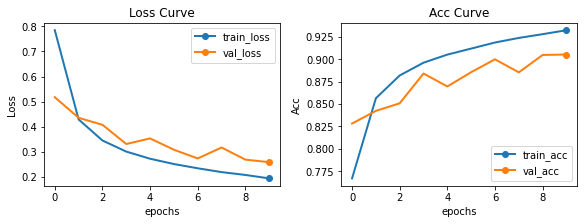

[Info] Saving the model at /content/drive/Othercomputers/My PC/drive/models/2023-02-09/DenseNet-151920.pth


In [11]:
trainer.fit(model,data)